# MVP Modeling

In the previous notebook, I learned the data I collected for `household_count` was really the number of people living in certain types of households, so it was another form of population count. 

The original census variable I used for `household_count` was `B09019_001E`. After exploring the [Census Data search tool](https://data.census.gov/cedsci/table?q=Housing%20Units&d=ACS%205-Year%20Estimates%20Detailed%20Tables&tid=ACSDT5Y2020.B25001). I think `B11012` would be a more better `household_count` metric. I will need to go back and recollect my Census data (which I want to do anyways so I can use the 2020 5-year ACS instead of the 2019 5-year ACS). I think `housing_unit_count` may be a better metric anyways. [This definition guide](https://www.census.gov/housing/hvs/definitions.pdf) outlines what a housing unit it and it seems to follow the definition I am looking for.

The beginning of this notebook is almost identical to `06_mvp.ipynb`, only I am using updated Census data as described above. 

My goal is to build a simple classification model. Two aspects I want to focus on are my machine learning workflow overall as well as error analysis. Both I will continue to work on throughout the project.

After updating Census Data:
- I was unable to collect data for 2020, so I am still using 2019 ACS 5-year
- Previously all data for `employed` was null. Changed census variable from `B24124_001E` to `B23025_004E`

### Business Problem
Predict whether or not a ZCTA has residential PV. As of right now, I do not see any reason to prioritize precision or recall, so I am going to look at accuracy, f1 score, and roc/auc.

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_score, recall_score

In [37]:
df = pd.read_csv('../data/data1.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

,zcta,state,lat,long,average_household_income,mean_household_income_lowest_quintile,mean_household_income_second_quintile,mean_household_income_third_quintile,mean_household_income_fourth_quintile,mean_household_income_highest_quintile,...,earth_temp,frost_days,earth_temp_amplitude,solar_azimuth_angle,num_systems,total_capacity,mean_system_size,median_system_size,num_incentives,num_policies
0,85610,Arizona,31.744197,109.722324,53713.747228,15735.0,28976.0,41584.0,60403.0,121871.0,...,17.40,3.3,18.02,-100.64,13.0,70.150,5.396154,5.3800,17,12
1,85614,Arizona,31.814301,110.919400,67347.031441,15092.0,33942.0,52059.0,78902.0,156740.0,...,20.51,0.8,18.44,-101.18,1012.0,7015.507,6.932319,5.9850,17,12
2,85624,Arizona,31.504971,110.692999,56508.955224,12085.0,26596.0,40793.0,63481.0,139590.0,...,20.51,0.8,18.44,-101.18,24.0,150.860,6.285833,5.8650,17,12
3,85629,Arizona,31.917838,111.019035,91646.185302,24218.0,55100.0,82356.0,109225.0,187332.0,...,20.51,0.8,18.44,-101.18,1186.0,8934.678,7.533455,7.2975,17,12
4,85630,Arizona,31.886572,110.181046,57186.339381,6123.0,16639.0,37332.0,58660.0,167178.0,...,17.40,3.3,18.02,-100.64,37.0,258.010,6.973243,6.4800,17,12


`long` should be negative

In [38]:
df['long'] = df['long'] * -1

Regression target is going to be `solar_density` which is the total capacity (kW) per 1,000 households in the ZCTA (`total_capacity` / (`household_count` / 1000)). Classification target will be `has_solar` indicating whether or not the ZCTA has any residential PV or not.

In [39]:
df[['household_count', 'housing_unit_count', 'housing_unit_occupied_count', 'total_population']]

,household_count,housing_unit_count,housing_unit_occupied_count,total_population
0,451,691,451,1071
1,13104,16986,13104,23777
2,536,860,536,1289
3,8559,9260,8559,25770
4,937,1226,937,1757
...,...,...,...,...
15735,165,315,165,380
15736,778,1683,778,1555
15737,536,1539,536,1233
15738,195,386,195,394


`household_count` is same as `housing_unit_occupied_count`. Just a little sanity check after updating my census data.

Look at `num_systems` to compute `has_solar`

In [40]:
df['num_systems'].isna().sum()

6345

When `num_systems` is null it indicates 0 systems. Replace null values in this column and other PV related columns with 0

In [41]:
df[['num_systems', 'total_capacity', 'mean_system_size', 'median_system_size']].replace(to_replace=np.nan, value=0, inplace=True)

/Users/mattcarr/opt/anaconda3/envs/solar-analysis/lib/python3.9/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [42]:
df['has_solar'] = df['num_systems'].apply(lambda num_systems: 1 if num_systems > 0 else 0)

In [43]:
df['has_solar'].value_counts()

1    9395
0    6345
Name: has_solar, dtype: int64

9,395 ZCTAs with at least some residential PV. 6,345 with none

## EDA

Explore correlations with `total_capacity`. Expect this to indicate strong predictors for `has_solar`

In [44]:
df.corr()['total_capacity'].abs().sort_values(ascending=False)[:25]

total_capacity                     1.000000
num_systems                        0.581219
heating_fuel_solar                 0.488186
mean_system_size                   0.482200
education_college                  0.296567
race_two_more                      0.275405
race_white                         0.261710
total_population                   0.258436
cloud_amount                       0.252805
solar_radiation                    0.252735
education_population               0.250520
employed                           0.238633
heating_fuel_all_gas               0.233004
relative_humidity                  0.227933
household_count                    0.227435
heating_fuel_housing_unit_count    0.227435
housing_unit_occupied_count        0.227435
housing_unit_count                 0.223613
num_policies                       0.221515
education_bachelor                 0.215954
heating_degree_days                0.207432
num_incentives                     0.205634
frost_days                      

In [64]:
df.corr()['has_solar'].abs().sort_values(ascending=False)[:25]

has_solar                                1.000000
cooling_degree_days                      0.355074
lat                                      0.345240
heating_fuel_all_gas                     0.307951
heating_fuel_electricity_rate            0.306834
air_temp                                 0.301707
earth_temp                               0.296628
heating_fuel_all_gas_rate                0.285805
education_high_school_graduate_rate      0.277368
average_years_of_education               0.270148
mean_household_income_third_quintile     0.266769
median_household_income                  0.266235
education_master_rate                    0.260210
mean_household_income_fourth_quintile    0.259578
mean_household_income_second_quintile    0.257791
heating_degree_days                      0.255539
education_bachelor_rate                  0.246079
housing_unit_median_gross_rent           0.236740
education_master                         0.226761
employed                                 0.224865


I want to start by looking at a subset of the data. Below I save all of the column names in `df` to a csv so I can begin to build a data dictionary.

In [11]:
# pd.DataFrame(df.columns, columns=['Column Name']).set_index('Column Name').to_csv('../references/main-data-dict.csv')

Below I define a list of columns I want to focus on first

In [46]:
COLS1 = ['zcta', 'state', 'lat', 'long', 'average_household_income', 'mean_household_income_top_5_percent', 'education_bachelor',
        'education_college', 'education_master', 'education_population', 'education_high_school_graduate', 'education_less_than_high_school',
        'heating_fuel_electricity', 'heating_fuel_all_gas', 'heating_fuel_coal_wood', 'heating_fuel_fuel_oil_kerosene', 'heating_fuel_none',
        'heating_fuel_other', 'race_asian', 'race_black_africa', 'race_two_more', 'race_white', 'age_median', 'employed', 'gini_index', 
        'total_area', 'total_population', 'per_capita_income', 'median_household_income', 'household_count', 'housing_unit_median_value',
        'housing_unit_median_gross_rent', 'air_temp', 'relative_humidity', 'solar_radiation', 'cloud_amount', 'cooling_degree_days',
        'heating_degree_days', 'earth_temp', 'num_incentives', 'num_policies', 'has_solar']

In [47]:
df1 = df[COLS1]
df1.head()

,zcta,state,lat,long,average_household_income,mean_household_income_top_5_percent,education_bachelor,education_college,education_master,education_population,...,air_temp,relative_humidity,solar_radiation,cloud_amount,cooling_degree_days,heating_degree_days,earth_temp,num_incentives,num_policies,has_solar
0,85610,Arizona,31.744197,-109.722324,53713.747228,186273.0,56,261,20,721,...,17.02,42.22,5.78,32.13,95.20,108.36,17.40,17,12,1
1,85614,Arizona,31.814301,-110.919400,67347.031441,271955.0,5034,7498,2577,21588,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
2,85624,Arizona,31.504971,-110.692999,56508.955224,195939.0,226,188,164,897,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
3,85629,Arizona,31.917838,-111.019035,91646.185302,290584.0,3482,5861,1696,16121,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
4,85630,Arizona,31.886572,-110.181046,57186.339381,298053.0,189,624,74,1395,...,17.02,42.22,5.78,32.13,95.20,108.36,17.40,17,12,1


41 columns will be a little easier to handle at first than 107 or however many I have in the full DataFrame.

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15740 entries, 0 to 15739
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   zcta                                 15740 non-null  int64  
 1   state                                15740 non-null  object 
 2   lat                                  15740 non-null  float64
 3   long                                 15740 non-null  float64
 4   average_household_income             15417 non-null  float64
 5   mean_household_income_top_5_percent  12913 non-null  float64
 6   education_bachelor                   15740 non-null  int64  
 7   education_college                    15740 non-null  int64  
 8   education_master                     15740 non-null  int64  
 9   education_population                 15740 non-null  int64  
 10  education_high_school_graduate       15740 non-null  int64  
 11  education_less_than_high_sch

Have to open output in new tab to check it fully. Only columns pandas recognizes missing data in are: 
- `average_household_income`
- `mean_household_income_top_5_percent`
- `per_capita_income`

From previous inspection of the data I know missing data can be indicated by values other than `np.nan`. A common one I saw in the Census data  was `-66666666` (or some magnitude of all 6's). I need to check for these values

In [49]:
df1.loc[df['average_household_income'] < 0]

,zcta,state,lat,long,average_household_income,mean_household_income_top_5_percent,education_bachelor,education_college,education_master,education_population,...,air_temp,relative_humidity,solar_radiation,cloud_amount,cooling_degree_days,heating_degree_days,earth_temp,num_incentives,num_policies,has_solar
14,85341,Arizona,31.879191,-112.798973,-inf,-666666666.0,0,0,0,0,...,22.44,37.92,5.87,26.11,189.39,38.90,23.49,17,12,0
30,85707,Arizona,32.179209,-110.886905,-inf,-666666666.0,12,42,0,54,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
31,85723,Arizona,32.180232,-110.965154,-inf,-666666666.0,0,0,0,0,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
32,85724,Arizona,32.240828,-110.945636,-inf,-666666666.0,0,0,0,0,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,0
33,85726,Arizona,32.204728,-110.945598,-inf,-666666666.0,0,0,0,0,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15456,54561,Wisconsin,46.097549,-89.513390,-inf,-666666666.0,0,0,0,0,...,4.35,85.31,3.55,67.34,11.09,422.45,4.32,18,6,0
15538,54985,Wisconsin,44.075066,-88.518469,-inf,-666666666.0,24,200,0,915,...,7.28,81.05,3.79,62.24,27.24,348.89,7.34,18,5,0
15563,54010,Wisconsin,44.734316,-92.465629,-inf,-666666666.0,0,0,0,0,...,6.03,82.45,3.73,63.49,22.45,382.35,5.81,18,5,0
15564,54307,Wisconsin,44.470363,-88.036686,-inf,-666666666.0,7,145,0,1017,...,7.44,81.52,3.65,64.08,26.23,343.75,7.71,18,5,0


In [50]:
income_cols = [col for col in df.columns if 'income' in col]
income_cols

['average_household_income',
 'mean_household_income_lowest_quintile',
 'mean_household_income_second_quintile',
 'mean_household_income_third_quintile',
 'mean_household_income_fourth_quintile',
 'mean_household_income_highest_quintile',
 'mean_household_income_top_5_percent',
 'per_capita_income',
 'median_household_income']

In [51]:
df.loc[df['average_household_income'] < 0, income_cols]

,average_household_income,mean_household_income_lowest_quintile,mean_household_income_second_quintile,mean_household_income_third_quintile,mean_household_income_fourth_quintile,mean_household_income_highest_quintile,mean_household_income_top_5_percent,per_capita_income,median_household_income
14,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666
30,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,22490.0,-666666666
31,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666
32,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666
33,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666
...,...,...,...,...,...,...,...,...,...
15456,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666
15538,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,761.0,-666666666
15563,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666
15564,-inf,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,-666666666.0,139.0,-666666666


310 rows missing practically all income data. Replace all instances of `-inf` or `-666666666.0` with `np.nan`

In [52]:
df.loc[:, income_cols] = df.loc[:, income_cols].replace(to_replace=[-np.inf, -666666666.0], value=np.nan)

Recreate `df1`

In [53]:
df1 = df.loc[:, COLS1]
df1.head()

,zcta,state,lat,long,average_household_income,mean_household_income_top_5_percent,education_bachelor,education_college,education_master,education_population,...,air_temp,relative_humidity,solar_radiation,cloud_amount,cooling_degree_days,heating_degree_days,earth_temp,num_incentives,num_policies,has_solar
0,85610,Arizona,31.744197,-109.722324,53713.747228,186273.0,56,261,20,721,...,17.02,42.22,5.78,32.13,95.20,108.36,17.40,17,12,1
1,85614,Arizona,31.814301,-110.919400,67347.031441,271955.0,5034,7498,2577,21588,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
2,85624,Arizona,31.504971,-110.692999,56508.955224,195939.0,226,188,164,897,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
3,85629,Arizona,31.917838,-111.019035,91646.185302,290584.0,3482,5861,1696,16121,...,20.02,37.71,5.75,31.87,142.35,64.42,20.51,17,12,1
4,85630,Arizona,31.886572,-110.181046,57186.339381,298053.0,189,624,74,1395,...,17.02,42.22,5.78,32.13,95.20,108.36,17.40,17,12,1


Visualize ZCTAs in dataset

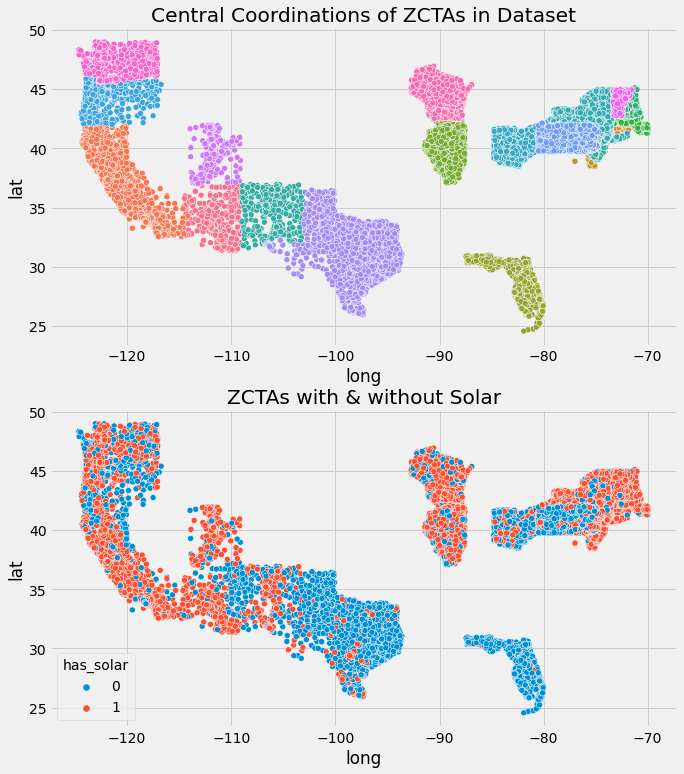

In [82]:
fig, ax = plt.subplots(nrows=2, figsize=(10,12))
sns.scatterplot(data=df1, x='long', y='lat', hue='state', ax=ax[0])
ax[0].set_title('Central Coordinations of ZCTAs in Dataset')
ax[0].legend().remove()

sns.scatterplot(data=df1, x='long', y='lat', hue='has_solar', ax=ax[1])
ax[1].set_title('ZCTAs with & without Solar');

Referring to the correlations above, `lat` has one of the strongest positive correlations with `has_solar`. This is reflected in the image above. There are fewer ZCTAs in southern states, mainly Texas and Florida, than there are in most northern states. There are some dense blue areas in the eastern region but nothing like those two states. This is interesting since I expect Texas and Florida to be environmentally prime for PV.

In [85]:
def plot_map(data, hue_var):

    fig, ax = plt.subplots(nrows=2, figsize=(10,12))
    sns.scatterplot(data=data, x='long', y='lat', hue='has_solar', ax=ax[0])
    ax[0].set_title('ZCTAs with & without Solar')

    sns.scatterplot(data=data, x='long', y='lat', hue=hue_var, ax=ax[1])
    ax[1].set_title('ZCTAs by {}'.format(hue_var));

    plt.show()

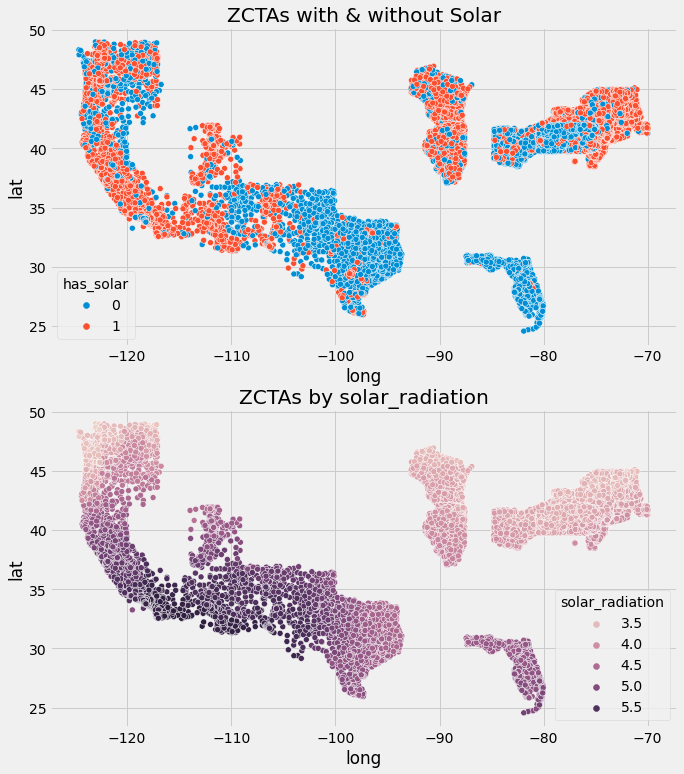

In [86]:
plot_map(data=df1, hue_var='solar_radiation')

Western Texas has some of the highest solar radiation in the country. Eastern Texas and Florida all look to be above 4.5 for the most part which is extremely high compared to other areas of the country, especially those with more PV systems. This is likely due to the political nature of these two states. I want to check `cloud_amount` as well as the number of incentives and policies

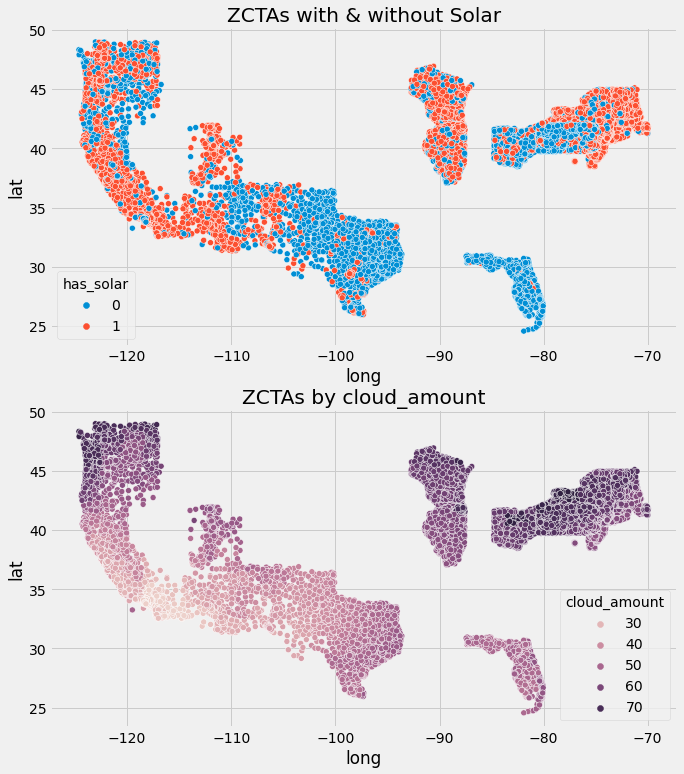

In [87]:
plot_map(data=df1, hue_var='cloud_amount')

Texas and Florida both have lower cloud amounts than a lot of the northern areas with more solar. Create new columns, `total_programs` which is total number of incentives and policies.

In [88]:
df1['total_programs'] = df1['num_incentives'] + df1['num_policies']

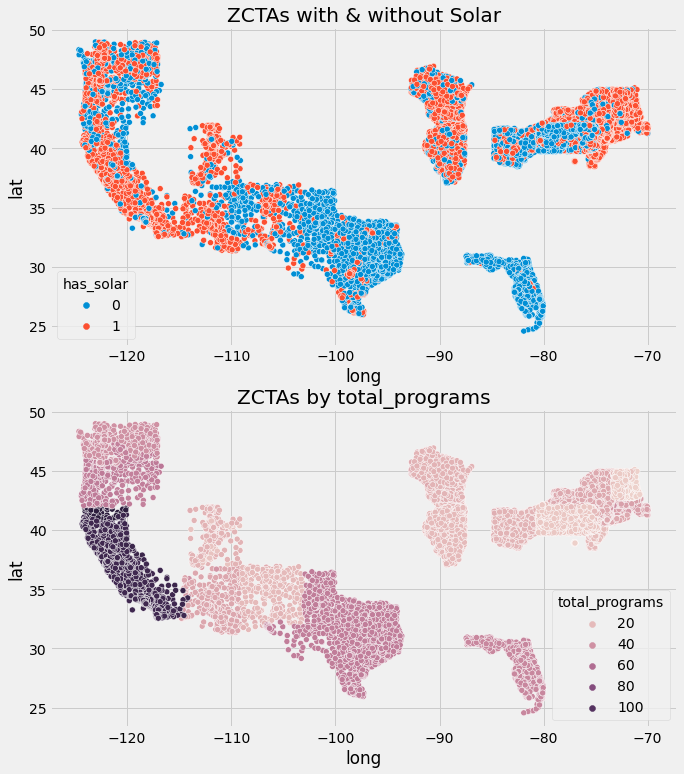

In [91]:
plot_map(data=df1, hue_var='total_programs')

Texas and Florida both offer more programs than expected. Texas is an interesting case since it's electric grid is essentially isolated from the rest of the country. I'd be curious to explore the states filling the rest of the southeast. More importantly, I would be interested in voting data for each ZCTA. DeepSolar gathered voting results from townhall.com ([2020 results](https://townhall.com/election/2020-results)), I am going to try and do the same. It will involve determining which ZCTA goes with which county and collecting the data. This will be done for future model iterations.

I also think the utility or balancing authority territory a ZCTA falls within would be a great predictor. 

Want to get this note in as I begin to ACTUALLY dive into this project. It's going to be pretty bad. Most of the time it's going to feel like I have no idea what I'm doing. I don't. Do it anyway. Spend the next few months getting used to doing work you don't know how to do. It'll serve you well. One hour per day.

In [100]:
df1.head()

,zcta,state,lat,long,average_household_income,mean_household_income_top_5_percent,education_bachelor,education_college,education_master,education_population,...,relative_humidity,solar_radiation,cloud_amount,cooling_degree_days,heating_degree_days,earth_temp,num_incentives,num_policies,has_solar,total_programs
0,85610.0,Arizona,31.744197,-109.722324,53713.747228,186273.0,56.0,261.0,20.0,721.0,...,42.22,5.78,32.13,95.20,108.36,17.40,17.0,12.0,1.0,29.0
1,85614.0,Arizona,31.814301,-110.919400,67347.031441,271955.0,5034.0,7498.0,2577.0,21588.0,...,37.71,5.75,31.87,142.35,64.42,20.51,17.0,12.0,1.0,29.0
2,85624.0,Arizona,31.504971,-110.692999,56508.955224,195939.0,226.0,188.0,164.0,897.0,...,37.71,5.75,31.87,142.35,64.42,20.51,17.0,12.0,1.0,29.0
3,85629.0,Arizona,31.917838,-111.019035,91646.185302,290584.0,3482.0,5861.0,1696.0,16121.0,...,37.71,5.75,31.87,142.35,64.42,20.51,17.0,12.0,1.0,29.0
4,85630.0,Arizona,31.886572,-110.181046,57186.339381,298053.0,189.0,624.0,74.0,1395.0,...,42.22,5.78,32.13,95.20,108.36,17.40,17.0,12.0,1.0,29.0


In [110]:
df1.corr()['has_solar'].sort_values(ascending=False)

has_solar                              1.000000
lat                                    0.345289
heating_fuel_all_gas                   0.307860
median_household_income                0.266235
average_household_income               0.256114
heating_degree_days                    0.255513
housing_unit_median_gross_rent         0.236359
education_master                       0.226663
employed                               0.224738
per_capita_income                      0.220605
education_bachelor                     0.218475
household_count                        0.216513
education_population                   0.215310
housing_unit_median_value              0.214140
total_population                       0.213201
race_white                             0.212046
race_two_more                          0.208875
heating_fuel_fuel_oil_kerosene         0.206744
education_college                      0.202547
heating_fuel_coal_wood                 0.192924
mean_household_income_top_5_percent    0

Explore `cooling_degree_days`

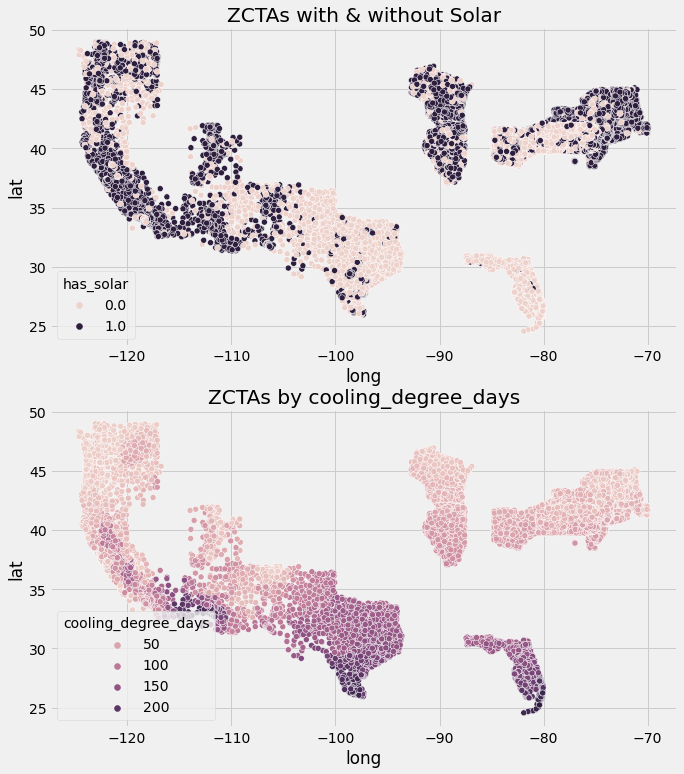

In [106]:
plot_map(data=df1, hue_var='cooling_degree_days')

ZCTAs with higher `cooling_degree_days` have less solar

<AxesSubplot:>

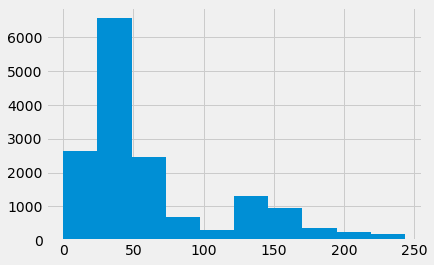

In [111]:
df1['cooling_degree_days'].hist()

<AxesSubplot:xlabel='cooling_degree_days', ylabel='Count'>

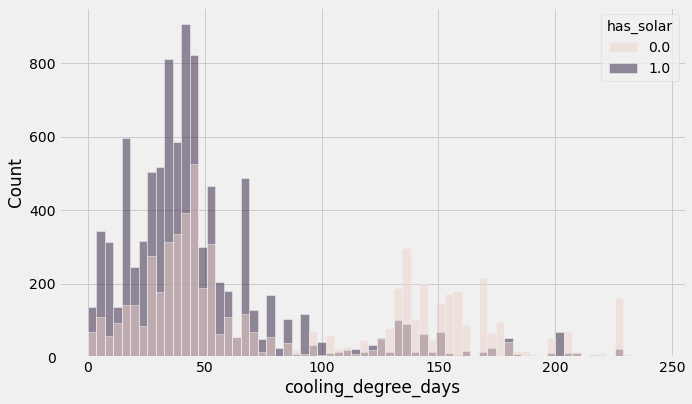

In [113]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df1, x='cooling_degree_days', hue='has_solar', ax=ax)

Median preferred over mean

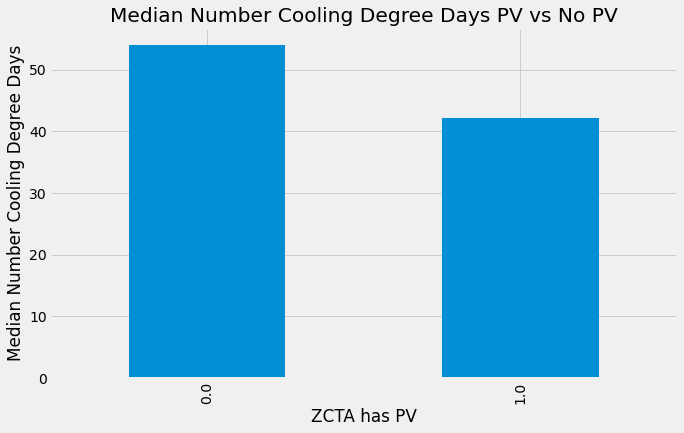

In [115]:
df1.groupby('has_solar').median()['cooling_degree_days'].plot.bar(figsize=(10,6)).set(
    title='Median Number Cooling Degree Days PV vs No PV',
    xlabel='ZCTA has PV',
    ylabel='Median Number Cooling Degree Days'
);

Interesting that `solar_radiation` has a negative correlation. I imagine this is due to Texas and Florida. Below I check correlation between `solar_radiation` and `has_solar` for all states except these two.

In [120]:
df1.loc[~df1['state'].isin(['Texas', 'Florida'])].corr()['has_solar'].sort_values(ascending=False)['solar_radiation']

0.1382600278336593

Did not increase as much as I expected. Explore `median_household_income`

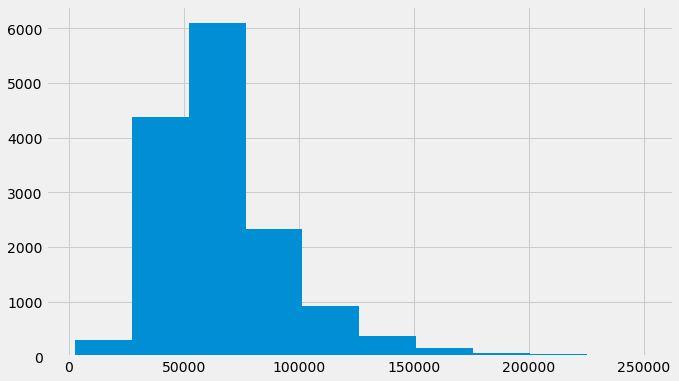

In [121]:
df1['median_household_income'].hist(figsize=(10,6));

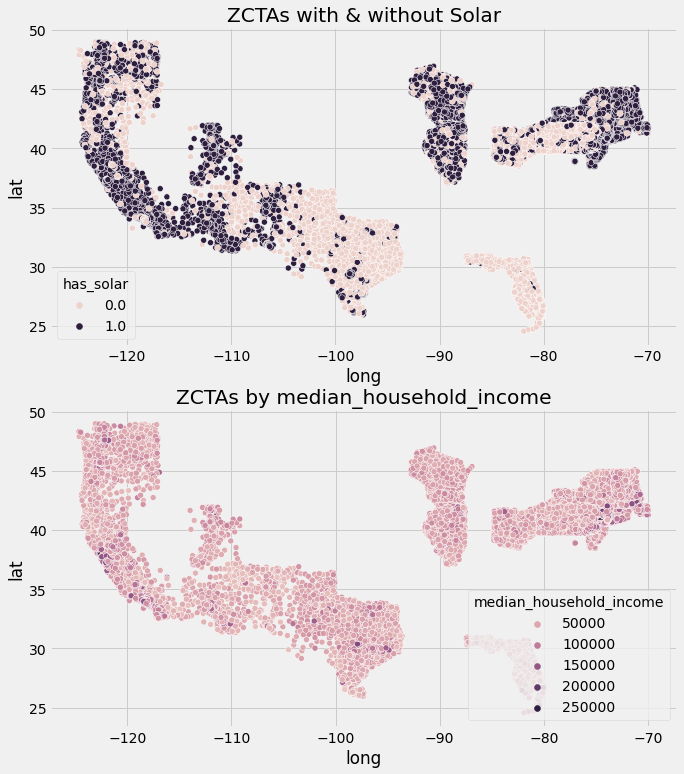

In [122]:
plot_map(data=df1, hue_var='median_household_income')

`median_household_income` distribution pretty positively skewed. Nothing too useful from map plot above.

In [140]:
def plot_dists(data, dist_var):
    fig, ax = plt.subplots(nrows=2, figsize=(12,8))
    sns.histplot(data=df1, x=dist_var, hue='has_solar', ax=ax[0])
    ax[0].set_title('Distribution of {} for PV & no PV'.format(dist_var))

    data.groupby('has_solar').median()[dist_var].plot.barh(ax=ax[1])
    ax[1].set_ylabel('ZCTA has PV')
    ax[1].set_xlabel('Median {}'.format(dist_var))

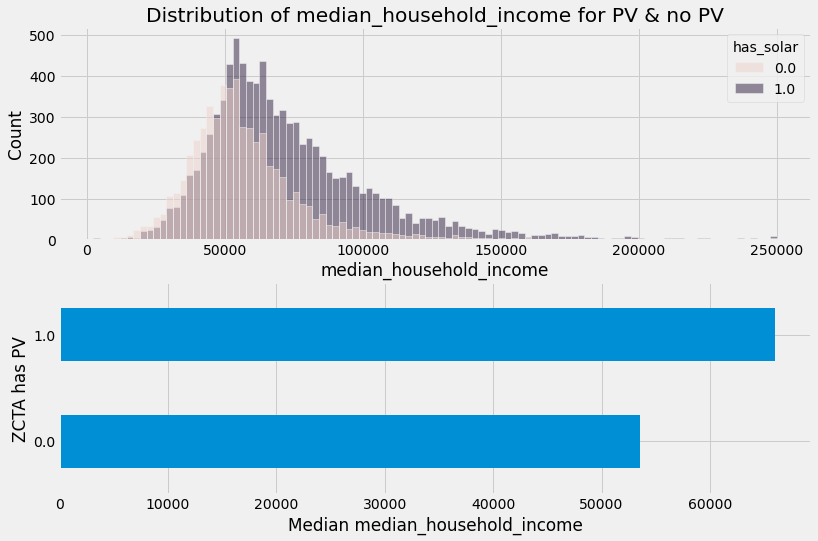

In [141]:
plot_dists(data=df1, dist_var='median_household_income')

More ZCTAs have solar than do not, distribution is slightly larger for that reason. It is also shifted to the right, ZCTAs with solar have slightly larger `median_household_income` than those who do not.

## Baseline Classifier

My baseline classification model will use `cooling_degree_days` and `median_household_income`.

I will be checking three metrics:
- accuracy
- f1-score
- roc auc curve

In [156]:
df1.loc[df1['has_solar'].isna()]

,zcta,state,lat,long,average_household_income,mean_household_income_top_5_percent,education_bachelor,education_college,education_master,education_population,...,relative_humidity,solar_radiation,cloud_amount,cooling_degree_days,heating_degree_days,earth_temp,num_incentives,num_policies,has_solar,total_programs
1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop rows where `has_solar` is missing. All data missing for these rows.

In [157]:
df1 = df1.loc[~df1['has_solar'].isna()]

In [158]:
# Separate target and features
y1 = df1['has_solar']
X1 = df1[['cooling_degree_days', 'median_household_income']]

In [159]:
y1.isna().sum()

0

In [160]:
X1.isna().sum()

cooling_degree_days           0
median_household_income    1044
dtype: int64

As I discovered earlier, `median_household_income` is a positively skewed normal distribution. I will use the median to fill missing values.

In [172]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=.2, random_state=42)

Calculate median `median_household_income` from `X_train1` and use to fill training and test data

In [173]:
median_income = X_train1['median_household_income'].median()

In [174]:
X_train1.loc[:, 'median_household_income'] = X_train1['median_household_income'].fillna(median_income)
X_test1.loc[:, 'median_household_income'] = X_test1['median_household_income'].fillna(median_income)

/Users/mattcarr/opt/anaconda3/envs/solar-analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Sanity check

In [175]:
X_train1.isna().sum()

cooling_degree_days        0
median_household_income    0
dtype: int64

In [176]:
X_test1.isna().sum()

cooling_degree_days        0
median_household_income    0
dtype: int64

Baseline model will be a simple LogisticRegression classifier

In [177]:
logreg1 = LogisticRegression(random_state=42)

In [178]:
logreg1.fit(X_train1, y_train1)

LogisticRegression(random_state=42)

In [179]:
train_preds1 = logreg1.predict(X_train1)
test_preds1 = logreg1.predict(X_test1)

In [180]:
def check_metrics(y_train, y_test, train_preds, test_preds):

    train_acc = accuracy_score(y_train, train_preds)
    train_f1 = f1_score(y_train, train_preds)
    train_roc = roc_auc_score(y_train, train_preds)

    test_acc = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)
    test_roc = roc_auc_score(y_test, test_preds)

    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('-------------------')
    print('Train F1 Score: ', train_f1)
    print('Test F1 Score: ', test_f1)
    print('-------------------')
    print('Train ROC: ', train_roc)
    print('Test ROC: ', test_roc)

In [181]:
check_metrics(y_train1, y_test1, train_preds1, test_preds1)

Train Accuracy:  0.6999761696719358
Test Accuracy:  0.6839263024142312
-------------------
Train F1 Score:  0.7766542487138548
Test F1 Score:  0.7646084693636149
-------------------
Train ROC:  0.6578124445950364
Test ROC:  0.6431621650475072


Baseline model actually performed really well. For the next iteration I will include a few more features:
- `air_temp`
- `heating_fuel_all_gas`
- `education_master`
- `race_white`

Rather than perform train test split every single time. I am going to perform one large one then select features from each subset for every model iteration

In [182]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns='has_solar'), df1['has_solar'], test_size=.2, random_state=42)

#### Model Iteration 2

In [183]:
model2_feats = ['cooling_degree_days', 'median_household_income', 'air_temp', 'heating_fuel_all_gas',
                'education_master', 'race_white']

In [184]:
X_train2 = X_train[model2_feats]
X_test2 = X_test[model2_feats]

In [185]:
X_train2.isna().sum()

cooling_degree_days          0
median_household_income    820
air_temp                     0
heating_fuel_all_gas         0
education_master             0
race_white                   0
dtype: int64

Use median of `median_household_income` to fill missing values again

In [186]:
X_train2.loc[:, 'median_household_income'] = X_train2['median_household_income'].fillna(median_income)
X_test2.loc[:, 'median_household_income'] = X_test2['median_household_income'].fillna(median_income)

/Users/mattcarr/opt/anaconda3/envs/solar-analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Once again I will be using a LogisticRegression model

In [187]:
logreg2 = LogisticRegression(random_state=42)

In [188]:
logreg2.fit(X_train2, y_train)

LogisticRegression(random_state=42)

In [189]:
train_preds2 = logreg2.predict(X_train2)
test_preds2 = logreg2.predict(X_test2)

In [190]:
check_metrics(y_train, y_test, train_preds2, test_preds2)

Train Accuracy:  0.728651997775836
Test Accuracy:  0.7102922490470139
-------------------
Train F1 Score:  0.7931702591426496
Test F1 Score:  0.7785332685769791
-------------------
Train ROC:  0.694110716682492
Test ROC:  0.6768117126614712


Additional features increased all metrics slightly.

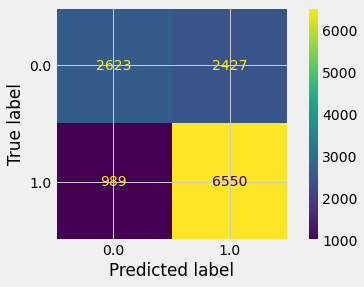

In [191]:
plot_confusion_matrix(logreg2, X_train2, y_train)

Many more false positive than false negatives. Makes sense due to class imbalance. 

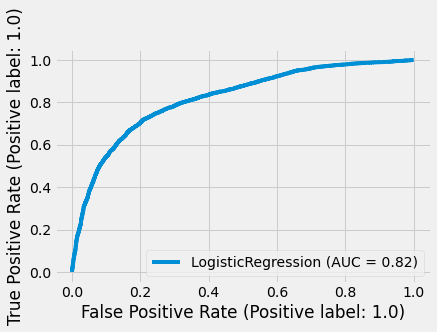

In [192]:
plot_roc_curve(logreg2, X_train2, y_train)

In [195]:
print("Train ROC: ", roc_auc_score(y_train, logreg2.predict_proba(X_train2)[:, 1]))
print("Test ROC: ", roc_auc_score(y_test, logreg2.predict_proba(X_test2)[:, 1]))

Train ROC:  0.8189245757046854
Test ROC:  0.8017727210553005


Forgot that ROC/AUC function takes probabilities instead of predicted classes. Performance is much stronger.

In [197]:
pd.DataFrame({'class': train_preds2, 'true': y_train, 'probs': logreg2.predict_proba(X_train2)[:, 1]})

,class,true,probs
949,1.0,1.0,0.649883
14143,1.0,1.0,0.689842
10715,1.0,0.0,0.964227
2993,0.0,0.0,0.133387
5127,1.0,1.0,0.730309
...,...,...,...
5193,1.0,1.0,0.907912
13421,0.0,1.0,0.031982
5392,1.0,1.0,0.711325
860,1.0,1.0,0.976909


A few instances where the model was very wrong (indices 10715, 13421). Changing probability threshold won't help in these cases. 

Below I expand `check_metrics` function

In [213]:
def check_metrics(model, X_train, X_test, y_train, y_test):

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_acc = accuracy_score(y_train, train_preds)
    train_prec = precision_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    train_f1 = f1_score(y_train, train_preds)
    train_roc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    test_acc = accuracy_score(y_test, test_preds)
    test_prec = precision_score(y_test, test_preds)
    test_recall = recall_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)
    test_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print('Train Accuracy: ', train_acc)
    print('Test Accuracy: ', test_acc)
    print('-------------------')
    print('Train Precision: ', train_prec)
    print('Test Precision: ', test_prec)
    print('-------------------')
    print('Train Recall: ', train_recall)
    print('Test Recall: ', test_recall)
    print('-------------------')
    print('Train F1 Score: ', train_f1)
    print('Test F1 Score: ', test_f1)
    print('-------------------')
    print('Train ROC: ', train_roc)
    print('Test ROC: ', test_roc)

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
    plot_confusion_matrix(model, X_train, y_train, ax=ax[0, 0])
    plot_roc_curve(model, X_train, y_train, ax=ax[0, 1])
    plot_confusion_matrix(model, X_test, y_test, ax=ax[1, 0])
    plot_roc_curve(model, X_test, y_test, ax=ax[1, 1])

Train Accuracy:  0.728651997775836
Test Accuracy:  0.7102922490470139
-------------------
Train Precision:  0.7296424195165423
Test Precision:  0.7086648983200707
-------------------
Train Recall:  0.8688154927709245
Test Recall:  0.8636853448275862
-------------------
Train F1 Score:  0.7931702591426496
Test F1 Score:  0.7785332685769791
-------------------
Train ROC:  0.8189245757046854
Test ROC:  0.8017727210553005


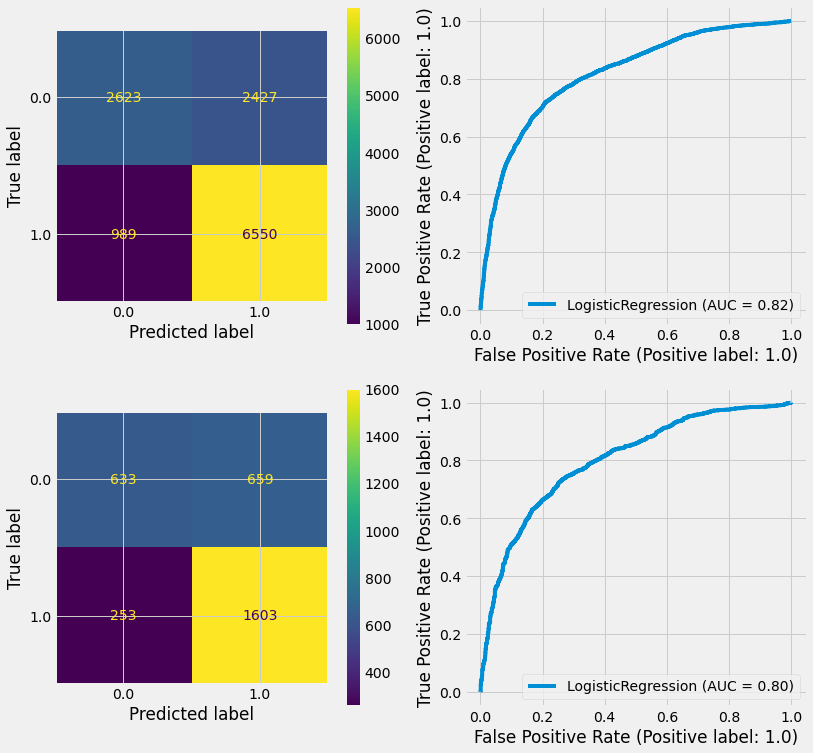

In [214]:
check_metrics(logreg2, X_train2, X_test2, y_train, y_test)

Add `gini_index`, `total_population`, `employed`

In [225]:
model3_feats = ['cooling_degree_days', 'median_household_income', 'air_temp', 'heating_fuel_all_gas',
                'education_master', 'race_white', 'gini_index', 'total_population', 'employed']

In [226]:
logreg3 = LogisticRegression(random_state=42)

In [227]:
X_train3 = X_train[model3_feats]
X_test3 = X_test[model3_feats]

In [228]:
X_train3.isna().sum()

cooling_degree_days          0
median_household_income    820
air_temp                     0
heating_fuel_all_gas         0
education_master             0
race_white                   0
gini_index                   0
total_population             0
employed                     0
dtype: int64

In [229]:
X_test3.isna().sum()

cooling_degree_days          0
median_household_income    224
air_temp                     0
heating_fuel_all_gas         0
education_master             0
race_white                   0
gini_index                   0
total_population             0
employed                     0
dtype: int64

In [230]:
X_train3.loc[:, 'median_household_income'] = X_train3['median_household_income'].fillna(median_income)
X_test3.loc[:, 'median_household_income'] = X_test3['median_household_income'].fillna(median_income)

/Users/mattcarr/opt/anaconda3/envs/solar-analysis/lib/python3.9/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [231]:
logreg3 = LogisticRegression(random_state=42)
logreg3.fit(X_train3, y_train)

LogisticRegression(random_state=42)

Train Accuracy:  0.6176821034236238
Test Accuracy:  0.610864040660737
-------------------
Train Precision:  0.611429038587312
Test Precision:  0.6035444699704627
-------------------
Train Recall:  0.9920413847990449
Test Recall:  0.9908405172413793
-------------------
Train F1 Score:  0.7565626422538061
Test F1 Score:  0.7501529675708749
-------------------
Train ROC:  0.7114421378468925
Test ROC:  0.7072929316349952


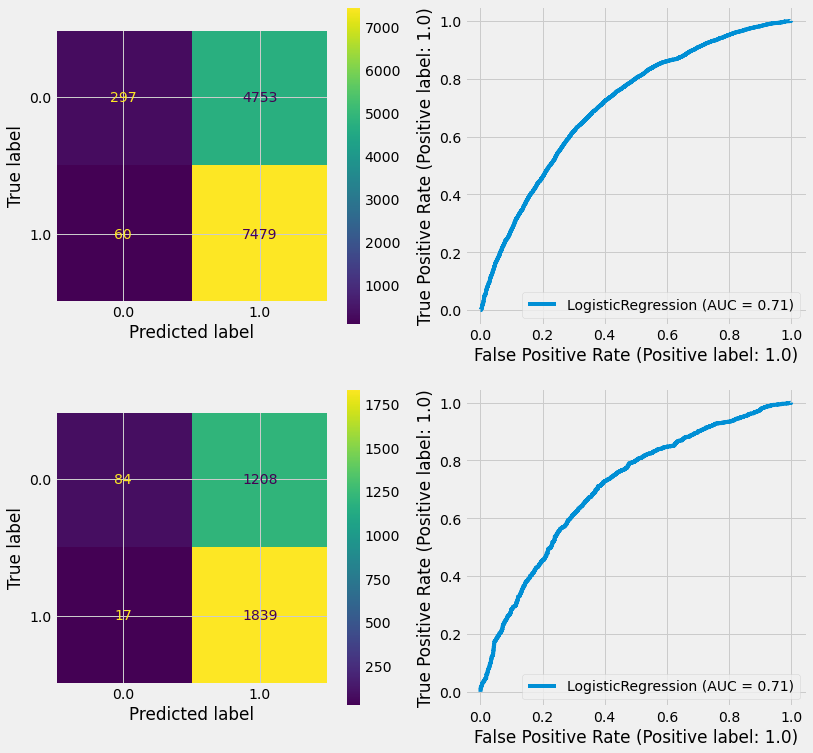

In [232]:
check_metrics(logreg3, X_train3, X_test3, y_train, y_test)

Addition of above features increased recall significantly but reduced scores for other metrics. Model 2 is best performing model